# Quantus + NLP

This tutorial demonstrates how to use the library for robustness evaluation
explanation of text classification models.
For this purpose, we use a pre-trained `Distilbert` model from [Huggingface](https://huggingface.co/models) and `GLUE/SST2` dataset [here](https://huggingface.co/datasets/sst2).

This is not a working example yet, and is meant only for demonstration purposes 
so far. For this demo, we use a (yet) unreleased version of Quantus.

Author: Artem Sereda

In [1]:
from __future__ import annotations

In [ ]:
# Use an unreleased version of Quantus.
!pip install 'quantus @ git+https://github.com/aaarrti/Quantus.git@nlp-domain' --no-deps
!pip install transformers datasets nlpaug tf_explain

In [146]:
import numpy as np
import pandas as pd
from datasets import load_dataset
import tensorflow as tf
from functools import partial
import logging
from typing import NamedTuple, List, Any
from transformers import AutoTokenizer, TFDistilBertForSequenceClassification, BertTokenizerFast
import quantus.nlp as qn
import matplotlib.pyplot as plt
import tensorflow_probability as tfp

# Suppress debug logs.
logging.getLogger("absl").setLevel(logging.WARNING)
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 1) Preliminaries

### 1.1 Load pre-trained model and tokenizer from [huggingface](https://huggingface.co/models) hub

In [10]:
MODEL_NAME = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = TFDistilBertForSequenceClassification.from_pretrained(MODEL_NAME)

Some layers from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 1.2 Load test split of [GLUE/SST2](https://huggingface.co/datasets/sst2) dataset

In [11]:
BATCH_SIZE = 8
dataset = load_dataset("sst2")["test"]
x_batch = dataset["sentence"][:BATCH_SIZE]

  0%|          | 0/3 [00:00<?, ?it/s]

Run an example inference, and demonstrate models predictions.

In [12]:
CLASS_NAMES = ["negative", "positive"]


def decode_labels(y_batch: np.ndarray, class_names: List[str]) -> List[str]:
    """A helper function to map integer labels to human-readable class names."""
    return [class_names[i] for i in y_batch]


# Run tokenizer.
tokens = tokenizer(x_batch, padding="longest", return_tensors="tf")
logits = model(**tokens).logits
y_batch = tf.argmax(tf.nn.softmax(logits), axis=1).numpy()

# Show the x, y data.
pd.DataFrame([x_batch, decode_labels(y_batch, CLASS_NAMES)]).T

,0,1
0,uneasy mishmash of styles and genres .,negative
1,this film 's relationship to actual tension is...,negative
2,"by the end of no such thing the audience , lik...",positive
3,director rob marshall went out gunning to make...,positive
4,lathan and diggs have considerable personal ch...,positive
5,a well-made and often lovely depiction of the ...,positive
6,none of this violates the letter of behan 's b...,negative
7,although it bangs a very cliched drum at times...,positive


### 1.3 Helper functions: visualise explanations

There are not many XAI libraries for NLP out there, so here we fully relly on our own implementations of explanation methods. This section write functions to visualise our explanations. 

In [85]:
def plot_textual_heatmap(explanations: List[qn.TokenSalience]):

    h_len = len(explanations)
    v_len = len(explanations[0].tokens)

    tokens = np.asarray([i.tokens for i in explanations]).reshape(-1)
    colors = np.asarray([i.salience for i in explanations]).reshape(-1)

    fig, axes = plt.subplots(
        h_len,
        v_len,
        figsize=(v_len, h_len * 0.5),
        gridspec_kw=dict(left=0.0, right=1.0),
    )
    for i, ax in enumerate(axes.ravel()):
        rect = plt.Rectangle((0, 0), 1, 1, color=(1.0, 1 - colors[i], 1 - colors[i]))
        ax.add_patch(rect)
        ax.text(0.5, 0.5, tokens[i], ha="center", va="center")
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.axis("off")

        ax = fig.add_axes([0, 0.05, 1, 0.9], fc=[0, 0, 0, 0])
    for axis in ["left", "right"]:
        ax.spines[axis].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    return plt

### 1.4 Helper functions: generate explanations

Write out functions to generate explanations using baseline methods: Gradient Norm and Integrated Gradients

In [191]:
@tf.function(jit_compile=True)
def normalize(x: tf.Tensor) -> tf.Tensor:
    """
    Scale attributions to be maximum 1.
    Parameters
    ----------
    x: attribtions

    Returns
    -------

    x: normalized attributions

    """
    abs = tf.abs(x)
    max = tf.reduce_max(abs)
    return abs / max


def explain_gradient_norm(model: TFDistilBertForSequenceClassification, token_ids, attention_mask, target: int, tokenizer):
    # Convert tokens to embeddings.
    embeddings = model.distilbert.get_input_embeddings()(input_ids=token_ids)
    with tf.GradientTape() as tape:
        tape.watch(embeddings)
        logits = model(
            None, inputs_embeds=embeddings, attention_mask=attention_mask
        ).logits
        logits_for_label = tf.gather(logits, axis=1, indices=target)

    # Compute gradients of logits with respect to embeddings.
    grads = tape.gradient(logits_for_label, embeddings)

    # Compute L2 norm of gradients.
    grad_norm = tf.linalg.norm(grads, axis=-1)

    return qn.TokenSalience(
        tokenizer.convert_ids_to_tokens(token_ids), normalize(grad_norm[0]).numpy()
    )


def explain_gradient_norm_batch(model: tf.keras.Model, inputs, targets, tokenizer):
    """A wrapper around explain_gradient_norm which allows calling it on batch"""
    tokens = tokenizer(inputs, return_tensors="tf", padding="longest")
    batch_size = len(targets)
    return [
        explain_gradient_norm(
            model,
            tokens["input_ids"][i],
            tokens["attention_mask"][i],
            targets[i],
            tokenizer,
        )
        for i in range(batch_size)
    ]


@tf.function(jit_compile=True)
def get_interpolated_inputs(baseline, target, num_steps) -> np.ndarray:
    """
    Gets num_step linearly interpolated inputs from baseline to target.
    Reference: https://github.com/PAIR-code/lit/blob/main/lit_nlp/components/gradient_maps.py#L238

    Returns
    -------
    interpolated_inputs: <float32>[num_steps, num_tokens, emb_size]
    """

    baseline = tf.cast(baseline, dtype=tf.float64)
    target = tf.cast(target, dtype=tf.float64)
    delta = target - baseline  # <float32>[num_tokens, emb_size]
    # Creates scale values array of shape [num_steps, num_tokens, emb_dim],
    # where the values in scales[i] are the ith step from np.linspace. <float32>[num_steps, 1, 1]
    scales = tf.linspace(0, 1, num_steps + 1)[:, tf.newaxis, tf.newaxis]
    shape = (num_steps + 1,) + delta.shape
    # <float32>[num_steps, num_tokens, emb_size]
    deltas = scales * tf.broadcast_to(delta, shape)
    interpolated_inputs = baseline + deltas
    return interpolated_inputs


def explain_int_grad(model, token_ids, attention_mask, target, tokenizer, num_steps=10):
    # Convert tokens to embeddings.
    embeddings = model.distilbert.get_input_embeddings()(input_ids=token_ids)[0]

    baseline = tf.zeros_like(embeddings)

    # Generate interpolation from 0 to embeddings.
    interpolated_embeddings = get_interpolated_inputs(baseline, embeddings, num_steps)
    interpolated_embeddings = tf.cast(interpolated_embeddings, tf.float32)
    interpolated_attention_mask = tf.stack(
        [attention_mask for i in range(num_steps + 1)]
    )

    with tf.GradientTape() as tape:
        tape.watch(interpolated_embeddings)
        logits = model(
            None,
            inputs_embeds=interpolated_embeddings,
            attention_mask=interpolated_attention_mask,
        ).logits
        logits_for_label = tf.gather(logits, axis=1, indices=target)

    # Compute gradients of logits with respect to interpolations.
    grads = tape.gradient(logits_for_label, interpolated_embeddings)

    # Integrate gradients.
    int_grad = tfp.math.trapz(tfp.math.trapz(grads, axis=0))

    return qn.TokenSalience(
        tokenizer.convert_ids_to_tokens(token_ids), normalize(int_grad).numpy()
    )


def explain_int_grad_batch(model, inputs, targets, tokenizer):
    """A wrapper around explain_int_grad which allows calling it on batch"""
    tokens = tokenizer(inputs, return_tensors="tf", padding="longest")
    batch_size = len(targets)
    return [
        explain_int_grad(
            model,
            tokens["input_ids"][i],
            tokens["attention_mask"][i],
            targets[i],
            tokenizer,
        )
        for i in range(batch_size)
    ]


# Create functions which match the signature required by Quantus.
explain_gradient_norm_func = partial(explain_gradient_norm_batch, tokenizer=tokenizer)
explain_int_grad_func = partial(explain_int_grad_batch, tokenizer=tokenizer)

### 1.5 Visualise the explanations.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

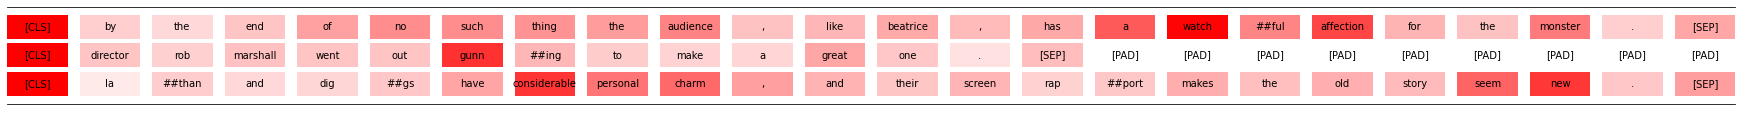

In [173]:
# Visualise GradNorm.
a_batch_grad_norm = explain_gradient_norm_func(model, x_batch[2:5], y_batch[2:5])
plot_textual_heatmap(a_batch_grad_norm)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

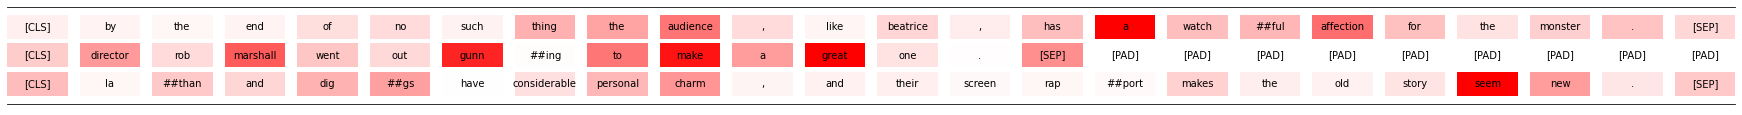

In [192]:
# Visualise IntegratedGradients explanations.
a_batch_int_grad = explain_int_grad_func(model, x_batch[2:5], y_batch[2:5])
plot_textual_heatmap(a_batch_int_grad)

## 2) Quantitative analysis using Quantus
For this example, we compute [Sensitivity](https://arxiv.org/abs/1901.09392) metric

In [183]:
# This is only a workaround to account for hardcoded attribute access in lib.
class ModelTuple(NamedTuple):
    model: Any
    tokenizer: Any


# This is also only a workaround to account for hardcoded attribute access in lib.
model_stub = ModelTuple(model, tokenizer)
model_stub.model.bert = model.distilbert
model_stub.model.bert.embeddings.word_embeddings = model.distilbert.embeddings.weight

Average Sensitivity captures the average change in explanations under slight perturbation

In [184]:
# Instantiate metric.
avg_sensitivity = qn.AvgSensitivity()

# Evaluate avg sensitivity for Gradient Norm.
avg_sensitivity_grad_norm = avg_sensitivity(
    model=model_stub,
    x_batch=x_batch,
    y_batch=y_batch,
    perturb_func=qn.change_spelling,
    explain_func=explain_gradient_norm_func,
).mean()

# Evaluate avg sensitivity for Integrated Gradients.
avg_sensitivity_int_grad = avg_sensitivity(
    model=model_stub,
    x_batch=x_batch,
    y_batch=y_batch,
    perturb_func=qn.change_spelling,
    explain_func=explain_int_grad_func,
).mean()

Maximum Sensitivity captures the maximal change in explanations under slight perturbation

In [186]:
# Instantiate metric.
max_sensitivity = qn.MaxSensitivity()

# Evaluate max sensitivity metric for Gradient Norm.
max_sensitivity_grad_norm = max_sensitivity(
    model=model_stub,
    x_batch=x_batch,
    y_batch=y_batch,
    perturb_func=qn.change_spelling,
    explain_func=explain_gradient_norm_func,
).mean()

# Evaluate max sensitivity metric for Integrated Gradients.
max_sensitivity_int_grad = max_sensitivity(
    model=model_stub,
    x_batch=x_batch,
    y_batch=y_batch,
    perturb_func=qn.change_spelling,
    explain_func=explain_int_grad_func,
).mean()

Display results in tabular form

In [187]:
# Reformat the results.
all_results = np.asarray(
    [
        [avg_sensitivity_grad_norm, avg_sensitivity_int_grad],
        [max_sensitivity_grad_norm, max_sensitivity_int_grad],
    ]
)

# Print out the evaluation outcome!
pd.DataFrame(
    all_results,
    columns=["Gradient Norm", "Integrated Gradients"],
    index=["Average Sensitivity", "Max Sensitivity"],
)

,Gradient Norm,Integrated Gradients
Average Sensitivity,0.180688,0.204321
Max Sensitivity,0.234248,0.275126
